<a href="https://colab.research.google.com/github/ladislasl/CNN_invar_rot/blob/main/polar_conv_mnist_cercleconcentriques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
!unzip mnist_rotation_new.zip

--2022-01-10 20:54:27--  http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58424278 (56M) [application/zip]
Saving to: ‘mnist_rotation_new.zip’

mnist_rotation_new. 100%[===================>]  55.72M  69.3MB/s    in 0.8s    

2022-01-10 20:54:28 (69.3 MB/s) - ‘mnist_rotation_new.zip’ saved [58424278/58424278]

Archive:  mnist_rotation_new.zip
  inflating: mnist_all_rotation_normalized_float_train_valid.amat  
  inflating: mnist_all_rotation_normalized_float_test.amat  


In [ ]:
import os
import numpy as np

In [ ]:
data = np.loadtxt('mnist_all_rotation_normalized_float_train_valid.amat')

In [ ]:
train_data = data[:10000]
val_data = data[10000:]
assert len(train_data) + len(val_data) == len(data)
train_features, train_labels = train_data[..., :-1], train_data[..., -1]
val_features, val_labels = val_data[..., :-1], val_data[..., -1]

In [ ]:
train_features = np.reshape(train_features, (-1, 28, 28))
val_features = np.reshape(val_features, (-1, 28, 28))

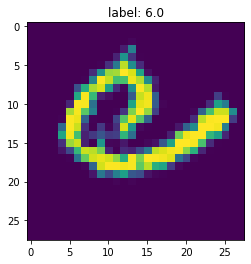

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_features[0])
plt.title('label: {}'.format(train_labels[0]))
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class RotMNISTDataset(Dataset):
    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, item):
        features = self.transform(self.features[item])

        return features.float(), int(self.labels[item])

    def __len__(self):
        return len(self.labels)

In [1]:
from torch.nn.modules.utils import _single, _pair, _triple


class Net(nn.Module):
    def __init__(self, conv_types, kernel_size=3, padding=0):
        super(Net, self).__init__()

        self.conv_layers = []
        # n_inputs_width_fc = 28
        for c, conv_type in enumerate(conv_types.split(' ')):
            if conv_type == 'C':
                conv_op = nn.Conv2d
            elif conv_type == 'P':
                conv_op = PolarConvNd
            else:
                raise ValueError(f'Unknown conv type {conv_type}')
            conv_args = [1 if c == 0 else 32 * 2**c, 32 * 2**(c+1), kernel_size, 1, padding]
            self.conv_layers.append(conv_op(*conv_args))
        self.conv_layers = nn.ModuleList(self.conv_layers)
        self.conv_types = conv_types

        self.adaptive_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.classification_layer = nn.Linear(32 * 2**(c+1), 10, bias=False)

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            x = F.relu(x)
        x = self.adaptive_pooling(x)
        x = self.flatten(x)
        x = self.classification_layer(x)
        return x


class GroupEquivariantNet(nn.Module):
    """ a CNN architecture (Z2CNN) with 7 layers of 3×3 convolutions (4×4 in the final layer), 
    20 channels in each layer, relu activation functions, batch normalization, dropout, and max-pooling after layer2 """
    def __init__(self, conv_types, kernel_size=3, padding=0):
        super(GroupEquivariantNet, self).__init__()

        self.conv_layers = []
        self.bn_layers = []
        assert len(conv_types.split(' ')) == 7, 'expects 7 conv layers'
        # n_inputs_width_fc = 28
        for c, conv_type in enumerate(conv_types.split(' ')):
            if conv_type == 'C':
                conv_op = nn.Conv2d
            elif conv_type == 'P':
                conv_op = PolarConvNd
            else:
                raise ValueError(f'Unknown conv type {conv_type}')
            conv_args = [1 if c == 0 else 20, 20, kernel_size, 1, padding]
            self.conv_layers.append(conv_op(*conv_args))
            self.bn_layers.append(nn.BatchNorm2d(20))
            # n_inputs_width_fc -= ((kernel_size // 2) - padding) * 2
        self.conv_layers = nn.ModuleList(self.conv_layers)
        self.bn_layers = nn.ModuleList(self.bn_layers)
        self.conv_types = conv_types

        self.max_pooling = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.2)

        self.adaptive_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.classification_layer = nn.Linear(80, 10, bias=False)

    def forward(self, x):
        for c, (conv_layer, bn_layer) in enumerate(zip(self.conv_layers, self.bn_layers)):
            x = conv_layer(x)
            x = bn_layer(x)
            x = F.relu(x)
            x = self.dropout(x)
            if c == 1:
              x = self.max_pooling(x)
        # x = self.adaptive_pooling(x)
        x = self.flatten(x)
        x = self.classification_layer(x)
        return x

    def __repr__(self):
        return 'GroupEquivariantNet(' + str(self.conv_types) + ')'


class PolarConvNd(torch.nn.modules.conv._ConvNd):
    """ Polar convolution """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=True, padding_mode='zeros', dimensions=2):
        self.init_kernel_size = kernel_size
        assert kernel_size % 2 == 1, 'expected kernel size to be odd, found %d' % kernel_size
        self.init_dimensions = dimensions

        base_vectors = torch.from_numpy(self.build_base_vectors()).float()
        self.true_base_vectors_shape = base_vectors.shape
        base_vectors = base_vectors.view(self.true_base_vectors_shape[0],
                                                   int(np.prod(self.true_base_vectors_shape[1:])))

        inferred_kernel_size = self.true_base_vectors_shape[0]
        _kernel_size = _single(inferred_kernel_size)
        _stride = _single(stride)
        _padding = _single(padding)
        _dilation = _single(dilation)
        super(PolarConvNd, self).__init__(
            in_channels, out_channels, _kernel_size, _stride, _padding, _dilation,
            False, _single(0), groups, bias, padding_mode)
        
        self.register_buffer('base_vectors', base_vectors)

        if dimensions == 2:
            self.reconstructed_stride = _pair(stride)
            self.reconstructed_padding = _pair(padding)
            self.reconstructed_dilation = _pair(dilation)
            self.reconstructed_conv_op = F.conv2d
        elif dimensions == 3:
            self.reconstructed_stride = _triple(stride)
            self.reconstructed_padding = _triple(padding)
            self.reconstructed_dilation = _triple(dilation)
            self.reconstructed_conv_op = F.conv3d
        else:
            raise ValueError('dimension %d not supported' % dimensions)

    def build_base_vectors(self):
        kernel_size = self.init_kernel_size
        middle = kernel_size // 2
        dimensions = self.init_dimensions

        base_vectors = []
        # Burning phase: determine the number of base vectors
        unique_distances = []
        if dimensions == 2:
            for i in range(kernel_size):
                for j in range(kernel_size):
                    i_ = abs(i - middle)
                    j_ = abs(j - middle)
                    unique_distances.append(int(i_ * i_ + j_ * j_))
        elif dimensions == 3:
            for i in range(kernel_size):
                for j in range(kernel_size):
                    for k in range(kernel_size):
                        i_ = abs(i - middle)
                        j_ = abs(j - middle)
                        k_ = abs(k - middle)
                        unique_distances.append(int(i_ * i_ + j_ * j_ + k_ * k_))
        unique_distances, distances_counts = np.unique(unique_distances, return_counts=True)
        unique_distances = np.sort(unique_distances)
        print(*zip(unique_distances, distances_counts), len(unique_distances))

        for unique_distance, n in zip(unique_distances, distances_counts):  # number of base vectors
            base_vector = np.zeros([kernel_size] * dimensions)
            if dimensions == 2:
                for i in range(kernel_size):
                    for j in range(kernel_size):
                        i_ = abs(i - middle)
                        j_ = abs(j - middle)
                        if int(i_ * i_ + j_ * j_) == unique_distance:
                            base_vector[i, j] = 1./n
            elif dimensions == 3:
                for i in range(kernel_size):
                    for j in range(kernel_size):
                        for k in range(kernel_size):
                            i_ = abs(i - middle)
                            j_ = abs(j - middle)
                            k_ = abs(k - middle)
                            if int(i_ * i_ + j_ * j_ + k_ * k_) == unique_distance:
                                base_vector[i, j, k] = 1./n
            base_vectors.append(base_vector)
        base_vectors = np.asarray(base_vectors)
        return base_vectors

    # @weak_script_method
    def forward(self, input):
        weight_size = self.weight.shape
        weight = torch.mm(self.weight.view(np.prod(weight_size[:-1]), weight_size[-1]), self.base_vectors) \
            .view(*weight_size[:-1], *self.true_base_vectors_shape[1:])
        return self.reconstructed_conv_op(input, weight, self.bias, self.reconstructed_stride,
                                          self.reconstructed_padding, self.reconstructed_dilation, self.groups)

    def __repr__(self):
        return ('PolarConv%dd' % self.init_dimensions) + '(' + self.extra_repr() + ')'

NameError: ignored

In [ ]:
kernel_size = 5
padding = kernel_size // 2
Net('C P C P', kernel_size, padding)

(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6


Net(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PolarConv2d(64, 128, kernel_size=(6,), stride=(1,), padding=(2,))
    (2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): PolarConv2d(256, 512, kernel_size=(6,), stride=(1,), padding=(2,))
  )
  (adaptive_pooling): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classification_layer): Linear(in_features=512, out_features=10, bias=False)
)

In [ ]:
torch.manual_seed(123)
device = torch.device("cuda")


def main(models_types, batch_size, learning_rate, n_epochs, kernel_size=3):
    cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    train_dataset = RotMNISTDataset(train_features, train_labels, transform)
    val_dataset = RotMNISTDataset(val_features, val_labels, transform)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, **cuda_kwargs)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, **cuda_kwargs)
    
    models = []
    optimizers = []
    for model_type in models_types:
        if isinstance(model_type, str):
            model = Net(model_type, kernel_size, padding=kernel_size // 2).to(device)
        else:
            model = model_type.to(device)
        models.append(model)
        optimizers.append(optim.Adam(model.parameters(), lr=learning_rate))
    loss = nn.CrossEntropyLoss()

    val_losses = [[] for _ in range(len(models))]
    for epoch in range(1, n_epochs + 1):
        train(models, device, train_dataloader, loss, optimizers, epoch, models_types)
        models_val_loss = val(models, device, val_dataloader, loss, models_types)
        [val_losses[i].append(model_val_loss) for i, model_val_loss in enumerate(models_val_loss)]
    return val_losses


def train(models, device, train_loader, loss_fct, optimizers, epoch, models_types):
    [model.train() for model in models]
    epoch_losses = [[] for _ in range(len(models))]
    corrects = [0 for _ in range(len(models))]
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for m, (model, optimizer) in enumerate(zip(models, optimizers)):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fct(output, target)
            loss.backward()
            optimizer.step()

            epoch_losses[m].append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            corrects[m] += pred.eq(target.view_as(pred)).sum().item()

            if batch_idx % 100 == 0:
              print('{}  Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f} ({:.4f}), Accuracy: {:.1f}%'.format(
                  models_types[m], epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader.dataset), loss.item(), np.mean(epoch_losses[m]),
                  100. * corrects[m] / (len(epoch_losses[m]) * batch_size)))


def val(models, device, val_loader, loss_fct, models_types):
    [model.eval() for model in models]
    val_losses = [0 for _ in range(len(models))]
    corrects = [0 for _ in range(len(models))]
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            for m, model in enumerate(models):
                output = model(data)
                val_losses[m] += loss_fct(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                corrects[m] += pred.eq(target.view_as(pred)).sum().item()

    val_losses = [val_loss / len(val_loader) for val_loss in val_losses]
    for val_loss, model_type, correct, val_loss in zip(val_losses, models_types, corrects, val_losses):
        print('\nval set: {} Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            model_type, val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
    return val_losses

In [ ]:
# computes number of parameters with same filter width
from prettytable import PrettyTable

def count_parameters(model, model_name):
    table = PrettyTable([model_name, "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(GroupEquivariantNet('C C C C C C C', kernel_size=3, padding=0), 'C C C C C C C')
count_parameters(GroupEquivariantNet('C C C C C C P', kernel_size=3, padding=0), 'C C C C C C P')
count_parameters(GroupEquivariantNet('C C C C C P P', kernel_size=3, padding=0), 'C C C C C P P')
count_parameters(GroupEquivariantNet('C C C C P P P', kernel_size=3, padding=0), 'C C C C P P P')
count_parameters(GroupEquivariantNet('C C C P P P P', kernel_size=3, padding=0), 'C C C P P P P')

+-----------------------------+------------+
|        C C C C C C C        | Parameters |
+-----------------------------+------------+
|     conv_layers.0.weight    |    180     |
|      conv_layers.0.bias     |     20     |
|     conv_layers.1.weight    |    3600    |
|      conv_layers.1.bias     |     20     |
|     conv_layers.2.weight    |    3600    |
|      conv_layers.2.bias     |     20     |
|     conv_layers.3.weight    |    3600    |
|      conv_layers.3.bias     |     20     |
|     conv_layers.4.weight    |    3600    |
|      conv_layers.4.bias     |     20     |
|     conv_layers.5.weight    |    3600    |
|      conv_layers.5.bias     |     20     |
|     conv_layers.6.weight    |    3600    |
|      conv_layers.6.bias     |     20     |
|      bn_layers.0.weight     |     20     |
|       bn_layers.0.bias      |     20     |
|      bn_layers.1.weight     |     20     |
|       bn_layers.1.bias      |     20     |
|      bn_layers.2.weight     |     20     |
|       bn

13400

In [ ]:
batch_size = 16
learning_rate = 2e-4
n_epochs = 20

In [ ]:
models = [
          GroupEquivariantNet('C C C C C C C', kernel_size=3, padding=0),
          GroupEquivariantNet('C C C C C C P', kernel_size=3, padding=0),
          GroupEquivariantNet('C C C C C P P', kernel_size=3, padding=0),
          GroupEquivariantNet('C C C C P P P', kernel_size=3, padding=0),
          GroupEquivariantNet('C C C P P P P', kernel_size=3, padding=0),
          ]
val_losses = main(models, batch_size, learning_rate, n_epochs, kernel_size=3)

(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
(0, 1) (1, 4) (2, 4) 3
GroupEquivariantNet(C C C C C C C)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.2925 (2.2925), Accuracy: 18.8%
GroupEquivariantNet(C C C C C C P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.3287 (2.3287), Accuracy: 0.0%
GroupEquivariantNet(C C C C C P P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.4869 (2.4869), Accuracy: 6.2%
GroupEquivariantNet(C C C C P P P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.2359 (2.2359), Accuracy: 12.5%
GroupEquivariantNet(C C C P P P P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.4127 (2.4127), Accuracy: 12.5%
GroupEquivariantNet(C C C C C C C)  Train Epoch: 1 [1600/10000 (1%)]	Loss: 2.1958 (2.3738), Accuracy: 11.3%
GroupEquivariantNet(C C C C C C P)  Train Epoch: 1 [1600/10000 (1%)]	Loss: 2.3222 (2.3799), Accuracy: 10.5%
GroupEquivariantNet(C C C C C P

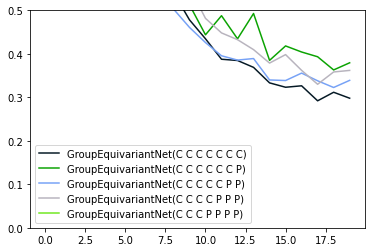

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs)
for val_loss, model_type in zip(val_losses, models):
    plt.plot(x, val_loss, label=str(model_type), c=np.random.rand(3,))
plt.ylim([0, .5])
plt.legend(loc='best')
plt.show()

In [ ]:
batch_size = 16
learning_rate = 2e-4
n_epochs = 100

In [ ]:
models = [
          GroupEquivariantNet('C C C C C C C', kernel_size=5, padding=1),
          GroupEquivariantNet('C C C C C C P', kernel_size=5, padding=1),
          GroupEquivariantNet('C C C C C P P', kernel_size=5, padding=1),
          GroupEquivariantNet('C C C C P P P', kernel_size=5, padding=1),
          GroupEquivariantNet('C C C P P P P', kernel_size=5, padding=1),
          ]
val_losses_kernel_5 = main(models, batch_size, learning_rate, n_epochs, kernel_size=None)

(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) 6
GroupEquivariantNet(C C C C C C C)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.3057 (2.3057), Accuracy: 12.5%
GroupEquivariantNet(C C C C C C P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.3990 (2.3990), Accuracy: 12.5%
GroupEquivariantNet(C C C C C P P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.5222 (2.5222), Accuracy: 6.2%
GroupEquivariantNet(C C C C P P P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.6469 (2.6469), Accuracy: 0.0%
GroupEquivariantNet(C C C P P P P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.4988 (2.4988), Accuracy: 0.0%
GroupEquivariantNet(C C C C C C C)  Tr

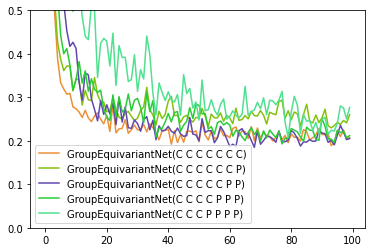

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs)
for val_loss, model_type in zip(val_losses_kernel_5, models):
    plt.plot(x, val_loss, label=str(model_type), c=np.random.rand(3,))
plt.ylim([0, .5])
plt.legend(loc='best')
plt.show()

In [ ]:
kernel_size = 7
padding = 2
models = [
          GroupEquivariantNet('C C C C C C C', kernel_size=kernel_size, padding=padding),
          GroupEquivariantNet('C C C C C C P', kernel_size=kernel_size, padding=padding),
          GroupEquivariantNet('C C C C C P P', kernel_size=kernel_size, padding=padding),
          GroupEquivariantNet('C C C C P P P', kernel_size=kernel_size, padding=padding),
          GroupEquivariantNet('C C C P P P P', kernel_size=kernel_size, padding=padding),
          ]
val_losses_kernel_5 = main(models, batch_size, learning_rate, n_epochs, kernel_size=None)

(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
(0, 1) (1, 4) (2, 4) (4, 4) (5, 8) (8, 4) (9, 4) (10, 8) (13, 8) (18, 4) 10
GroupEquivariantNet(C C C C C C C)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.2809 (2.2809), Accuracy: 6.2%
GroupEquivariantNet(C C C C C C P)  Train Epoch: 1 [0/10000 (0%)]	Loss: 2.2681 (2.2681), Accuracy: 18.8%
GroupEquivariantNet(C C C C C P

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs)
for val_loss, model_type in zip(val_losses_kernel_5, models):
    plt.plot(x, val_loss, label=str(model_type), c=np.random.rand(3,))
plt.ylim([0, .5])
plt.legend(loc='best')
plt.show()

In [ ]:
classic_val_losses = main('classic', batch_size, learning_rate, n_epochs)

In [ ]:
proposed3_val_losses = main('proposed', batch_size, learning_rate, n_epochs)

In [ ]:
proposed5_val_losses = main('proposed', batch_size, learning_rate, n_epochs, 5)

In [ ]:
mixed3_val_losses = main('mixed', batch_size, learning_rate, n_epochs, 5)

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs)
plt.plot(x, classic_val_losses, label='classic 3')
plt.plot(x, proposed3_val_losses, label='proposed 3', color='green')
plt.plot(x, proposed5_val_losses, label='proposed 5', color='red')
plt.plot(x, mixed3_val_losses, label='mixed 3', color='orange')
plt.legend(loc='best')
plt.show()